In [2]:
!pip install s3fs
!pip install smart_open
!pip install statsmodels

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 31.4MB/s 
     |████████████████████████████████| 6.5MB 36.7MB/s 
     |████████████████████████████████| 266kB 46.1MB/s 
     |████████████████████████████████| 153kB 49.4MB/s 
     |████████████████████████████████| 552kB 40.6MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=355f549ad88ddbe3d908d97ab285edee6ca2b535c1b136cae4c753e8e3d6ae87
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import s3fs
import statsmodels as sm
from statsmodels.compat import lzip

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
genome_scores_df = pd.read_csv('s3://citadel-datathon-datasets/genome-scores.csv')
genome_tags_df = pd.read_csv('s3://citadel-datathon-datasets/genome-tags.csv')
links_df = pd.read_csv('s3://citadel-datathon-datasets/links.csv')
movies_df = pd.read_csv('s3://citadel-datathon-datasets/movies.csv')
ratings_df = pd.read_csv('s3://citadel-datathon-datasets/ratings.csv')
tags_df = pd.read_csv('s3://citadel-datathon-datasets/tags.csv')
movie_industry_df = pd.read_csv('s3://citadel-datathon-datasets/movie_industry.csv',encoding='latin-1')
oscar_awards_df = pd.read_csv('s3://citadel-datathon-datasets/the_oscar_award.csv')

In [5]:
dataframes = {
    'genome_scores_df': genome_scores_df, 
    'genome_tags_df': genome_tags_df, 
    'links_df': links_df, 
    'movies_df': movies_df, 
    'ratings_df': ratings_df, 
    'tags_df': tags_df, 
    'movie_industry_df': movie_industry_df, 
    'oscar_awards_df': oscar_awards_df
}

In [6]:
for name, df in dataframes.items():
  print(name+': ', df.head())

for name, df in dataframes.items():
  print(name+': ', df.keys())

genome_scores_df:     movieId  tagId  relevance
0        1      1    0.02900
1        1      2    0.02375
2        1      3    0.05425
3        1      4    0.06875
4        1      5    0.16000
genome_tags_df:     tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
links_df:     movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
movies_df:     movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
ratings_df:     userId  movieId  rating   timestamp
0       1      307   

In [7]:
general_movies_df = movies_df.join(genome_scores_df.set_index('movieId'), on='movieId').join(genome_tags_df.set_index('tagId'), on='tagId').join(links_df.set_index('movieId'), on='movieId')
general_movies_df[:20]

,movieId,title,genres,tagId,relevance,tag,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,0.02900,007,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,0.02375,007 (series),114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,0.05425,18th century,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,0.06875,1920s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,0.16000,1930s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,0.19525,1950s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,0.07600,1960s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,0.25200,1970s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9.0,0.22750,1980s,114709,862.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,0.02400,19th century,114709,862.0


In [8]:
movie_industry_df.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


By Zijian:

**Linear regression model: average rating by relevance**

Generate average rating for each movie:

To be used as outputs:

In [9]:
movies_ratings_df = movies_df.join(ratings_df.set_index('movieId'), on = "movieId")
movie_avg_ratings = movies_ratings_df.groupby('movieId')[['movieId','rating']].mean()
movie_avg_ratings

,movieId,rating
movieId,,
1,1,3.886649
2,2,3.246583
3,3,3.173981
4,4,2.874540
5,5,3.077291
...,...,...
193876,193876,3.000000
193878,193878,2.000000
193880,193880,2.000000


Generate matrix of relevances on tags:

To be used as inputs.

In [10]:
relevance_to_rating_df = movies_df.join(genome_scores_df.set_index("movieId"), how = "inner", on = "movieId")
relevance_matrix_df = relevance_to_rating_df.set_index(["movieId","tagId"])["relevance"].unstack()
relevance_matrix_df

tagId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,0.58700,0.09425,0.17800,0.00700,0.03525,0.21450,0.01350,0.09725,0.66825,0.25725,0.35725,0.30225,0.04975,0.01300,0.07475,0.07050,0.13050,0.10525,0.90700,0.60850,0.03700,0.23675,0.30075,0.06200,0.03450,0.27325,0.11775,0.00750,0.02200,0.01450,...,0.14225,0.48100,0.34225,0.52750,0.36600,0.01325,0.07950,0.06675,0.04925,0.13125,0.00375,0.12100,0.27650,0.01675,0.02425,0.42850,0.06725,0.01175,0.02450,0.60275,0.09600,0.04400,0.05975,0.03725,0.10700,0.71175,0.08250,0.10025,0.05325,0.07450,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,0.08900,0.09800,0.16325,0.00650,0.00450,0.02825,0.01100,0.11950,0.62400,0.37350,0.51525,0.50100,0.20875,0.26200,0.08800,0.19500,0.14375,0.05300,0.97800,0.12375,0.01100,0.07875,0.06850,0.07525,0.05600,0.23675,0.06175,0.01875,0.02725,0.01500,...,0.08100,0.41150,0.22125,0.18750,0.35200,0.01875,0.05225,0.03450,0.02600,0.05275,0.00450,0.03875,0.19225,0.01525,0.01825,0.38950,0.09450,0.02600,0.01300,0.31100,0.08725,0.06500,0.02125,0.27025,0.38625,0.21475,0.20075,0.13150,0.01650,0.06500,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,0.02850,0.05900,0.08550,0.00475,0.00525,0.03500,0.00700,0.10750,0.15400,0.15025,0.24525,0.19000,0.10250,0.01725,0.05200,0.07350,0.09225,0.09675,0.32050,0.09725,0.01275,0.03400,0.05950,0.05925,0.03050,0.15925,0.05575,0.02975,0.04100,0.01825,...,0.10325,0.13175,0.19550,0.11925,0.04925,0.01700,0.05450,0.03225,0.02875,0.07225,0.01875,0.04525,0.15800,0.53250,0.02675,0.24075,0.06800,0.01850,0.03825,0.13450,0.14475,0.04075,0.02475,0.01675,0.02900,0.21775,0.02125,0.32325,0.02250,0.06875,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,0.02750,0.03375,0.07750,0.01075,0.00325,0.02650,0.01700,0.13775,0.13950,0.11500,0.51350,0.45850,0.10775,0.01625,0.06850,0.05725,0.06500,0.68975,0.14650,0.10475,0.01375,0.03500,0.04875,0.03325,0.02300,0.07700,0.11075,0.00900,0.01300,0.00500,...,0.09725,0.13400,0.18575,0.12875,0.05750,0.02950,0.03925,0.03075,0.01875,0.05700,0.01325,0.01950,0.31650,0.07650,0.02425,0.22025,0.06450,0.01975,0.01675,0.15250,0.04950,0.15125,0.03350,0.02075,0.03850,0.11450,0.02600,0.97625,0.01775,0.28200,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,0.02825,0.03175,0.05675,0.00825,0.00300,0.02425,0.01425,0.14725,0.14475,0.17400,0.25750,0.18800,0.08575,0.02075,0.04025,0.05400,0.11775,0.13225,0.15250,0.10200,0.01200,0.03350,0.07025,0.02575,0.03525,0.05500,0.04100,0.02525,0.05175,0.00600,...,0.08950,0.14425,0.16875,0.12450,0.06050,0.01475,0.05650,0.03275,0.02725,0.07200,0.00525,0.02475,0.13350,0.64450,0.01875,0.29300,0.05425,0.01450,0.02350,0.17000,0.09475,0.06850,0.02700,0.02125,0.03450,0.10700,0.02900,0.30650,0.01875,0.07625,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185435,0.10625,0.10775,0.03025,0

Merge (inner) input and output:


In [11]:
Rename = {}
for s in relevance_matrix_df.columns:
  if type(s) == int:
    Rename[s] = "relevance to tag " + str(s)
relevance_matrix_df.rename(columns = Rename, inplace = True)
relevance_matrix_df

tagId,relevance to tag 1,relevance to tag 2,relevance to tag 3,relevance to tag 4,relevance to tag 5,relevance to tag 6,relevance to tag 7,relevance to tag 8,relevance to tag 9,relevance to tag 10,relevance to tag 11,relevance to tag 12,relevance to tag 13,relevance to tag 14,relevance to tag 15,relevance to tag 16,relevance to tag 17,relevance to tag 18,relevance to tag 19,relevance to tag 20,relevance to tag 21,relevance to tag 22,relevance to tag 23,relevance to tag 24,relevance to tag 25,relevance to tag 26,relevance to tag 27,relevance to tag 28,relevance to tag 29,relevance to tag 30,relevance to tag 31,relevance to tag 32,relevance to tag 33,relevance to tag 34,relevance to tag 35,relevance to tag 36,relevance to tag 37,relevance to tag 38,relevance to tag 39,relevance to tag 40,...,relevance to tag 1089,relevance to tag 1090,relevance to tag 1091,relevance to tag 1092,relevance to tag 1093,relevance to tag 1094,relevance to tag 1095,relevance to tag 1096,relevance to tag 1097,relevance to tag 1098,relevance to tag 1099,relevance to tag 1100,relevance to tag 1101,relevance to tag 1102,relevance to tag 1103,relevance to tag 1104,relevance to tag 1105,relevance to tag 1106,relevance to tag 1107,relevance to tag 1108,relevance to tag 1109,relevance to tag 1110,relevance to tag 1111,relevance to tag 1112,relevance to tag 1113,relevance to tag 1114,relevance to tag 1115,relevance to tag 1116,relevance to tag 1117,relevance to tag 1118,relevance to tag 1119,relevance to tag 1120,relevance to tag 1121,relevance to tag 1122,relevance to tag 1123,relevance to tag 1124,relevance to tag 1125,relevance to tag 1126,relevance to tag 1127,relevance to tag 1128
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,0.58700,0.09425,0.17800,0.00700,0.03525,0.21450,0.01350,0.09725,0.66825,0.25725,0.35725,0.30225,0.04975,0.01300,0.07475,0.07050,0.13050,0.10525,0.90700,0.60850,0.03700,0.23675,0.30075,0.06200,0.03450,0.27325,0.11775,0.00750,0.02200,0.01450,...,0.14225,0.48100,0.34225,0.52750,0.36600,0.01325,0.07950,0.06675,0.04925,0.13125,0.00375,0.12100,0.27650,0.01675,0.02425,0.42850,0.06725,0.01175,0.02450,0.60275,0.09600,0.04400,0.05975,0.03725,0.10700,0.71175,0.08250,0.10025,0.05325,0.07450,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,0.08900,0.09800,0.16325,0.00650,0.00450,0.02825,0.01100,0.11950,0.62400,0.37350,0.51525,0.50100,0.20875,0.26200,0.08800,0.19500,0.14375,0.05300,0.97800,0.12375,0.01100,0.07875,0.06850,0.07525,0.05600,0.23675,0.06175,0.01875,0.02725,0.01500,...,0.08100,0.41150,0.22125,0.18750,0.35200,0.01875,0.05225,0.03450,0.02600,0.05275,0.00450,0.03875,0.19225,0.01525,0.01825,0.38950,0.09450,0.02600,0.01300,0.31100,0.08725,0.06500,0.02125,0.27025,0.38625,0.21475,0.20075,0.13150,0.01650,0.06500,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,0.02850,0.05900,0.08550,0.00475,0.00525,0.03500,0.00700,0.10750,0.15400,0.15025,0.24525,0.19000,0.10250,0.01725,0.05200,0.07350,0.09225,0.09675,0.32050,0.09725,0.01275,0.03400,0.05950,0.05925,0.03050,0.15925,0.05575,0.02975,0.04100,0.01825,...,0.10325,0.13175,0.19550,0.11925,0.04925,0.01700,0.05450,0.03225,0.02875,0.07225,0.01875,0.04525,0.15800,0.53250,0.02675,0.24075,0.06800,0.01850,0.03825,0.13450,0.14475,0.04075,0.02475,0.01675,0.02900,0.21775,0.02125,0.32325,0.02250,0.06875,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,0.02750,0.03375,0.07750,0.01075,0.00325,0.02650,0.01700,0.13775,0.13950,0.11500,0.51350,0.45850,0.10775,0.01625,0.06850,0.05725,0.06500,0.68975,0.14650,0.10475,0.01375,0.03500,0.04875,0.03325,0.02300,0.07700,0.

In [12]:
relevance_to_rating_df = relevance_matrix_df.join(movie_avg_ratings.set_index("movieId"), how="inner", on="movieId")
relevance_to_rating_df

,relevance to tag 1,relevance to tag 2,relevance to tag 3,relevance to tag 4,relevance to tag 5,relevance to tag 6,relevance to tag 7,relevance to tag 8,relevance to tag 9,relevance to tag 10,relevance to tag 11,relevance to tag 12,relevance to tag 13,relevance to tag 14,relevance to tag 15,relevance to tag 16,relevance to tag 17,relevance to tag 18,relevance to tag 19,relevance to tag 20,relevance to tag 21,relevance to tag 22,relevance to tag 23,relevance to tag 24,relevance to tag 25,relevance to tag 26,relevance to tag 27,relevance to tag 28,relevance to tag 29,relevance to tag 30,relevance to tag 31,relevance to tag 32,relevance to tag 33,relevance to tag 34,relevance to tag 35,relevance to tag 36,relevance to tag 37,relevance to tag 38,relevance to tag 39,relevance to tag 40,...,relevance to tag 1090,relevance to tag 1091,relevance to tag 1092,relevance to tag 1093,relevance to tag 1094,relevance to tag 1095,relevance to tag 1096,relevance to tag 1097,relevance to tag 1098,relevance to tag 1099,relevance to tag 1100,relevance to tag 1101,relevance to tag 1102,relevance to tag 1103,relevance to tag 1104,relevance to tag 1105,relevance to tag 1106,relevance to tag 1107,relevance to tag 1108,relevance to tag 1109,relevance to tag 1110,relevance to tag 1111,relevance to tag 1112,relevance to tag 1113,relevance to tag 1114,relevance to tag 1115,relevance to tag 1116,relevance to tag 1117,relevance to tag 1118,relevance to tag 1119,relevance to tag 1120,relevance to tag 1121,relevance to tag 1122,relevance to tag 1123,relevance to tag 1124,relevance to tag 1125,relevance to tag 1126,relevance to tag 1127,relevance to tag 1128,rating
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,0.58700,0.09425,0.17800,0.00700,0.03525,0.21450,0.01350,0.09725,0.66825,0.25725,0.35725,0.30225,0.04975,0.01300,0.07475,0.07050,0.13050,0.10525,0.90700,0.60850,0.03700,0.23675,0.30075,0.06200,0.03450,0.27325,0.11775,0.00750,0.02200,0.01450,...,0.48100,0.34225,0.52750,0.36600,0.01325,0.07950,0.06675,0.04925,0.13125,0.00375,0.12100,0.27650,0.01675,0.02425,0.42850,0.06725,0.01175,0.02450,0.60275,0.09600,0.04400,0.05975,0.03725,0.10700,0.71175,0.08250,0.10025,0.05325,0.07450,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,3.886649
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,0.08900,0.09800,0.16325,0.00650,0.00450,0.02825,0.01100,0.11950,0.62400,0.37350,0.51525,0.50100,0.20875,0.26200,0.08800,0.19500,0.14375,0.05300,0.97800,0.12375,0.01100,0.07875,0.06850,0.07525,0.05600,0.23675,0.06175,0.01875,0.02725,0.01500,...,0.41150,0.22125,0.18750,0.35200,0.01875,0.05225,0.03450,0.02600,0.05275,0.00450,0.03875,0.19225,0.01525,0.01825,0.38950,0.09450,0.02600,0.01300,0.31100,0.08725,0.06500,0.02125,0.27025,0.38625,0.21475,0.20075,0.13150,0.01650,0.06500,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,3.246583
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,0.02850,0.05900,0.08550,0.00475,0.00525,0.03500,0.00700,0.10750,0.15400,0.15025,0.24525,0.19000,0.10250,0.01725,0.05200,0.07350,0.09225,0.09675,0.32050,0.09725,0.01275,0.03400,0.05950,0.05925,0.03050,0.15925,0.05575,0.02975,0.04100,0.01825,...,0.13175,0.19550,0.11925,0.04925,0.01700,0.05450,0.03225,0.02875,0.07225,0.01875,0.04525,0.15800,0.53250,0.02675,0.24075,0.06800,0.01850,0.03825,0.13450,0.14475,0.04075,0.02475,0.01675,0.02900,0.21775,0.02125,0.32325,0.02250,0.06875,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,3.173981
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,0.02750,0.03375,0.07750,0.01075,0.00325,0.02650,0.01700,0.13775,0.13950,0.11500,0.51350,0.45850,0.10775,0.01625,0.06850,0.05725,0.06500,0.68975,0.14650,0.10475,0.01375,0.03500,0.04875,0.03325,0.02300,0.07700,0.11075,0.00900,0.0

Linear regression:

In [13]:
from sklearn.linear_model import LinearRegression
X_relevance_to_rating = relevance_to_rating_df.iloc[:,:-1].to_numpy()
y_relevance_to_rating = relevance_to_rating_df.iloc[:,-1].to_numpy()
model = LinearRegression().fit(X_relevance_to_rating, y_relevance_to_rating)
r_sq = model.score(X_relevance_to_rating, y_relevance_to_rating)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('coefficients:', model.coef_)

coefficient of determination: 0.9861084225287181
intercept: 3.473498699729801
coefficients: [-0.01600591 -0.0524091  -0.00839631 ... -0.04068168 -0.13186876
  0.06650179]


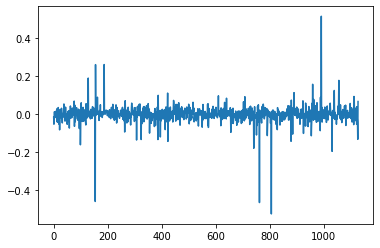

In [14]:
plt.plot(model.coef_)

Linear regression using statsmodels and evaluation


In [15]:
import statsmodels.api as sm
LR_model = sm.OLS(y_relevance_to_rating, sm.add_constant(X_relevance_to_rating))
LR_results = LR_model.fit()
#print("coefficients:", results.params)
LR_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     758.1
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:14:32   Log-Likelihood:                 18966.
No. Observations:               13176   AIC:                        -3.567e+04
Df Residuals:                   12047   BIC:                        -2.722e+04
Df Model:                        1128                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4735      0.019    178.897      0.000       3.435       3.512
x1            -0.0160      0.018     -0.868      0.386      -0.052       0.020
x2            -0.0524      0.016     -3.303      0.001      -0.084      -0.021
x3            -0.0084      0.008     -1.111      0.266      -0.023       0.006
x4             0.0130      0.012      1.099      0.272      -0.010       0.036
x5            -0.0081      0.006     -1.408      0.159      -0.019       0.003
x6            -0.0010      0.009     -0.109      0.913      -0.019       0.017
x7            -0.0173      0.009     -2.005      0.045      -0.034      -0.000
x8            -0.0010      0.007     -0.141      0.888      -0.015       0.013
x9             0.0138      0.008      1.687      0.092      -0.002       0.030
x10           -0.0040      0.010     -0.398      0.690      -0.024       0.016
x11           -0.0009      0.011     -0.085      0.932      -0.022       0.020
x12            0.0222      0.008      2.831      0.005       0.007       0.038
x13           -0.0393      0.009     -4.227      0.000      -0.058      -0.021
x14            0.0296      0.021      1.420      0.156      -0.011       0.070
x15           -0.0091      0.034     -0.269      0.788      -0.075       0.057
x16           -0.0428      0.016     -2.615      0.009      -0.075      -0.011
x17            0.0008      0.017      0.049      0.961      -0.032       0.033
x18            0.0349      0.008      4.253      0.000       0.019       0.051
x19           -0.0162      0.007     -2.161      0.031      -0.031      -0.002
x20           -0.0518      0.010     -5.165      0.000      -0.071      -0.032
x21           -0.0171      0.010     -1.651      0.099      -0.037       0.003
x22            0.0140      0.008      1.676      0.094      -0.002       0.030
x23           -0.0821      0.012     -7.001      0.000      -0.105      -0.059
x24           -0.0028      0.018     -0.151      0.880      -0.039       0.033
x25            0.0248      0.011      2.313      0.021       0.004       0.046
x26           -0.0044      0.008     -0.555      0.579      -0.020       0.011
x27           -0.0038      0.007     -0.520      0.603      -0.018       0.010
x28           -0.0145      0.006     -2.368      0.018      -0.027      -0.003
x29           -0.0196      0.007     -2.760      0.006      -0.033      -0.006
x30            0.0312      0.007      4.645      0.000       0.018       0.044
x31            0.0015      0.015      0.102      0.919      -0.028       0.031
x32           -0.0162      0.012     -1.335      0.182      -0.040       0.008
x33           -0.0457      0.013     -3.651      0.000      -0.070      -0.021
x34            0.0024      0.008      0.308      0.758      -0.013       0.018
x35           -0.0009      0.009     -0.097      0.922      -0.019       0.017
x3

A function to compute the mean square error:

In [16]:
def compute_LR_MSE(X, y, model):
  m, n = X.shape
  y_hat = model.predict(X) 
  MSE = (y_hat - y).dot(y_hat - y)/m
  return MSE

Mean square error on the whole dataset:

In [17]:
compute_LR_MSE(sm.add_constant(X_relevance_to_rating), y_relevance_to_rating, LR_results)

0.0032906357914446035

Basic analysis shows that the linear model is potentially be a good predictor, with R_sq 0.986 and MES of 0.00329. However, this model can still suffer from underfitting, overfitting. Now we are to further evaluate this model.

Also colinearity within predictors can also be a factor. For example, the tags "boring" and "boring!", "gangster" and "gangsters" have strong coorelations. But this in not our priority since it has low impact on the quality of predictions. 

Shuffle and spliting dataset into training, crossvalidation and testing sets:


In [18]:
m,n = relevance_to_rating_df.shape
relevance_to_rating_tr, relevance_to_rating_cv, relevance_to_rating_ts = np.split(relevance_to_rating_df.sample(frac=1,random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_tr.shape)
print("cross validation set shape", relevance_to_rating_cv.shape)
print("test set shape", relevance_to_rating_ts.shape)


training set shape (7905, 1129)
cross validation set shape (2635, 1129)
test set shape (2636, 1129)


Preform linear regression on the training set:

In [19]:
X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-1]
y_relevance_to_rating_tr = relevance_to_rating_tr[:,-1]

LR_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
LR_results = LR_model.fit()
print("coefficients:", LR_results.params)
#LR_results.summary()

coefficients: [ 3.46961941 -0.01561629 -0.04570244 ... -0.05309574 -0.1163633
  0.06658196]


Compute MSE:

In [20]:
X_relevance_to_rating_ts = relevance_to_rating_ts[:,:-1]
y_relevance_to_rating_ts = relevance_to_rating_ts[:,-1]
X_relevance_to_rating_cv = relevance_to_rating_cv[:,:-1]
y_relevance_to_rating_cv = relevance_to_rating_cv[:,-1]
LR_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_results)
LR_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_results)
LR_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_results)
print("Training MSE:", LR_MSE_tr)
print("Testing MSE:", LR_MSE_ts)
print("Cross validation MSE:", LR_MSE_cv)

Training MSE: 0.0030916829328949654
Testing MSE: 0.0042700406625309885
Cross validation MSE: 0.004198035796423508


The linear regression model gives us predictions with very small MSE on both the training set and test set. This means that our model is a good predictor of the average rating of a movie. However the MSE on the test set is around 40% great that on the training set. This means our linear model is overfitting. To reduce overfitting, we are going to introduce regulization on coefficients.

In [21]:
LR_reg_model = sm.OLS(y_relevance_to_rating_tr, sm.add_constant(X_relevance_to_rating_tr))
alpha = 1
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
print("coefficients:", LR_reg_results.params)

coefficients: [ 2.90835505e+00 -7.46046307e-04 -6.13642509e-04 ...  2.85621985e-03
 -4.26905827e-03  7.27329112e-04]


Compute MSE with regulization (L2 penalities). Remark: adding L1 penalities is possible but computationally expensive.

In [22]:
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

Training MSE: 0.07841508069628886
Cross validation MSE: 0.07474906253175125
Test MSE: 0.07708733981882576


Tune the regularization parameter alpha:

In [23]:
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
  Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
  Alpha[0] = 0 # do not penalize the constant coefficient
  LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
  LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
  LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
  print("When alpha =", alpha)
  print("Training MSE:", LR_reg_MSE_tr)
  print("Cross validation MSE:", LR_reg_MSE_cv)

When alpha = 0
Training MSE: 0.003091682932894965
Cross validation MSE: 0.004198035796423508
When alpha = 0.0001
Training MSE: 0.003102767592585134
Cross validation MSE: 0.004156087683969431
When alpha = 0.0003
Training MSE: 0.0031552534655132193
Cross validation MSE: 0.004146002552012279
When alpha = 0.001
Training MSE: 0.0033954506277925805
Cross validation MSE: 0.0042919072863463045
When alpha = 0.003
Training MSE: 0.00404228709059551
Cross validation MSE: 0.004850415705553385
When alpha = 0.01
Training MSE: 0.005914315080549091
Cross validation MSE: 0.006628869993527429
When alpha = 0.03
Training MSE: 0.01051316837418636
Cross validation MSE: 0.01101677505054574
When alpha = 0.1
Training MSE: 0.023242707560558292
Cross validation MSE: 0.022921108319952987
When alpha = 0.3
Training MSE: 0.044931334135733456
Cross validation MSE: 0.04311618108357622
When alpha = 1
Training MSE: 0.07841508069628886
Cross validation MSE: 0.07474906253175125


Best cross validation error is obtained at alpha = 0.0003. Also both alpha = 0.0001 and 0.001 give us similar results, so finer tuning is not necessary. We take alpha = 0.0003, and obtain:


In [24]:
alpha = 0.0003
Alpha = np.ones(X_relevance_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_reg_results = LR_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_tr), y_relevance_to_rating_tr, LR_reg_results)
LR_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv), y_relevance_to_rating_cv, LR_reg_results)
LR_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts), y_relevance_to_rating_ts, LR_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_reg_MSE_tr)
print("Cross validation MSE:", LR_reg_MSE_cv)
print("Test MSE:", LR_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0031552534655132193
Cross validation MSE: 0.004146002552012279
Test MSE: 0.004223270448739299


In [61]:
l = len(y_relevance_to_rating_ts)
predictions_df = pd.DataFrame(y_relevance_to_rating_ts.reshape(l,1), columns = ["rating"])
predictions_df["predicted rating"] = pd.DataFrame(LR_reg_results.predict(sm.add_constant(X_relevance_to_rating_ts)).reshape(l,1))
predictions_df

,rating,predicted rating
0,2.907767,2.934740
1,3.293478,3.133494
2,2.889768,2.881689
3,3.923891,3.861976
4,3.776786,3.811657
...,...,...
2631,3.162791,3.170285
2632,3.272727,3.226029
2633,2.382353,2.447497
2634,3.485294,3.407351


In [45]:

l = y_relevance_to_rating_ts.size
index_values = np.arange(y_relevance_to_rating_ts.size)
predictions_df["rating"] = pd.DataFrame(y_relevance_to_rating_ts.reshape(l,1))
predictions_df

ValueError: ignored

Now we add genres into this regression model.

Grab individual genres.

In [ ]:
genre_labels = set()
for s in movies_df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
genre_labels

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

Expand ['genres'] into columns with boolean data.

In [ ]:
movies_genres_df = movies_df.copy()
for label in genre_labels:
  movies_genres_df["genre: " + label] = movies_genres_df["genres"].str.contains(label).astype("int")
# movies_genres_df.drop(columns=["genre: (no genres listed)"])
movies_genres_df

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,movieId,title,genres,genre: Film-Noir,genre: Sci-Fi,genre: Mystery,genre: Children,genre: Thriller,genre: Horror,genre: Western,genre: Crime,genre: Animation,genre: Drama,genre: War,genre: Adventure,genre: (no genres listed),genre: Documentary,genre: Musical,genre: Fantasy,genre: Romance,genre: Action,genre: IMAX,genre: Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
58094,193878,Les tribulations d'une caissière (2011),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58095,193880,Her Name Was Mumu (2016),Drama,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0


Create table including both genres and relevances information:

In [ ]:
relevance_genres_to_rating_df = movies_genres_df.set_index("movieId").join(relevance_to_rating_df, how = "inner", on="movieId")
relevance_genres_to_rating_df = relevance_genres_to_rating_df.drop(columns = ["genres", "title"])
relevance_genres_to_rating_df

,genre: Film-Noir,genre: Sci-Fi,genre: Mystery,genre: Children,genre: Thriller,genre: Horror,genre: Western,genre: Crime,genre: Animation,genre: Drama,genre: War,genre: Adventure,genre: (no genres listed),genre: Documentary,genre: Musical,genre: Fantasy,genre: Romance,genre: Action,genre: IMAX,genre: Comedy,relevance to tag 1,relevance to tag 2,relevance to tag 3,relevance to tag 4,relevance to tag 5,relevance to tag 6,relevance to tag 7,relevance to tag 8,relevance to tag 9,relevance to tag 10,relevance to tag 11,relevance to tag 12,relevance to tag 13,relevance to tag 14,relevance to tag 15,relevance to tag 16,relevance to tag 17,relevance to tag 18,relevance to tag 19,relevance to tag 20,...,relevance to tag 1090,relevance to tag 1091,relevance to tag 1092,relevance to tag 1093,relevance to tag 1094,relevance to tag 1095,relevance to tag 1096,relevance to tag 1097,relevance to tag 1098,relevance to tag 1099,relevance to tag 1100,relevance to tag 1101,relevance to tag 1102,relevance to tag 1103,relevance to tag 1104,relevance to tag 1105,relevance to tag 1106,relevance to tag 1107,relevance to tag 1108,relevance to tag 1109,relevance to tag 1110,relevance to tag 1111,relevance to tag 1112,relevance to tag 1113,relevance to tag 1114,relevance to tag 1115,relevance to tag 1116,relevance to tag 1117,relevance to tag 1118,relevance to tag 1119,relevance to tag 1120,relevance to tag 1121,relevance to tag 1122,relevance to tag 1123,relevance to tag 1124,relevance to tag 1125,relevance to tag 1126,relevance to tag 1127,relevance to tag 1128,rating
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,0.58700,0.09425,0.17800,0.00700,0.03525,0.21450,0.01350,0.09725,0.66825,0.25725,...,0.48100,0.34225,0.52750,0.36600,0.01325,0.07950,0.06675,0.04925,0.13125,0.00375,0.12100,0.27650,0.01675,0.02425,0.42850,0.06725,0.01175,0.02450,0.60275,0.09600,0.04400,0.05975,0.03725,0.10700,0.71175,0.08250,0.10025,0.05325,0.07450,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225,3.886649
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,0.08900,0.09800,0.16325,0.00650,0.00450,0.02825,0.01100,0.11950,0.62400,0.37350,...,0.41150,0.22125,0.18750,0.35200,0.01875,0.05225,0.03450,0.02600,0.05275,0.00450,0.03875,0.19225,0.01525,0.01825,0.38950,0.09450,0.02600,0.01300,0.31100,0.08725,0.06500,0.02125,0.27025,0.38625,0.21475,0.20075,0.13150,0.01650,0.06500,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850,3.246583
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,0.02850,0.05900,0.08550,0.00475,0.00525,0.03500,0.00700,0.10750,0.15400,0.15025,...,0.13175,0.19550,0.11925,0.04925,0.01700,0.05450,0.03225,0.02875,0.07225,0.01875,0.04525,0.15800,0.53250,0.02675,0.24075,0.06800,0.01850,0.03825,0.13450,0.14475,0.04075,0.02475,0.01675,0.02900,0.21775,0.02125,0.32325,0.02250,0.06875,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750,3.173981
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,0.02750,0.03375,0.07750,0.01075,0.00325,0.02650,0.01700,0.13775,0.13950,0.11500,...,0.13400,0.18575,0.12875,0.05750,0.02950,0.03925,0.03075,0.01875,0.05700,0.01325,0.01950,0.31650,0.07650,0.02425,0.22025,0.06450,0.01975,0.01675,0.15250,0.04950,0.15125,0.03350,0.02075,0.03850,0.11450,0.02600,0.97625,0.01775,0.28200,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500,2.874540
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,0.02825,0.03175,0.05675,0.00825,0.00300,0.02425,0.01425,0.14725,0.14475,0.17400,...,0.14425,0.16875,0.12450,0.06

Preform the linear regression the same way as above:

In [ ]:
m,n = relevance_genres_to_rating_df.shape
relevance_genres_to_rating_tr, relevance_genres_to_rating_cv, relevance_genres_to_rating_ts = np.split(relevance_genres_to_rating_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_genres_to_rating_tr.shape)
print("cross validation set shape", relevance_genres_to_rating_cv.shape)
print("test set shape", relevance_genres_to_rating_ts.shape)
X_relevance_genres_to_rating_tr = relevance_genres_to_rating_tr[:,:-1]
y_relevance_genres_to_rating_tr = relevance_genres_to_rating_tr[:,-1]
X_relevance_genres_to_rating_cv = relevance_genres_to_rating_cv[:,:-1]
y_relevance_genres_to_rating_cv = relevance_genres_to_rating_cv[:,-1]
X_relevance_genres_to_rating_ts = relevance_genres_to_rating_ts[:,:-1]
y_relevance_genres_to_rating_ts = relevance_genres_to_rating_ts[:,-1]
LR_rel_genres_reg_model = sm.OLS(y_relevance_genres_to_rating_tr, sm.add_constant(X_relevance_genres_to_rating_tr))

for alpha in [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]:
  Alpha = np.ones(X_relevance_genres_to_rating_tr.shape[1]+1 ) * alpha
  Alpha[0] = 0 # do not penalize the constant coefficient
  LR_rel_genres_reg_results = LR_rel_genres_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
  LR_rel_genres_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_genres_to_rating_tr), y_relevance_genres_to_rating_tr, LR_rel_genres_reg_results)
  LR_rel_genres_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_genres_to_rating_cv), y_relevance_genres_to_rating_cv, LR_rel_genres_reg_results)
  print("When alpha =", alpha)
  print("Training MSE:", LR_rel_genres_reg_MSE_tr)
  print("Cross validation MSE:", LR_rel_genres_reg_MSE_cv)

training set shape (7905, 1149)
cross validation set shape (2635, 1149)
test set shape (2636, 1149)
When alpha = 0
Training MSE: 0.003067625568199255
Cross validation MSE: 0.004218790346605282
When alpha = 0.0001
Training MSE: 0.003078685941601298
Cross validation MSE: 0.004180170950060061
When alpha = 0.0003
Training MSE: 0.0031311079276220887
Cross validation MSE: 0.004174786900139508
When alpha = 0.001
Training MSE: 0.003371117352786824
Cross validation MSE: 0.004329603290212556
When alpha = 0.003
Training MSE: 0.004017242367622472
Cross validation MSE: 0.004895590413712742
When alpha = 0.01
Training MSE: 0.005885309825486202
Cross validation MSE: 0.0066729520169798015
When alpha = 0.03
Training MSE: 0.010437302228807862
Cross validation MSE: 0.011019730930275223
When alpha = 0.1
Training MSE: 0.022984452800097213
Cross validation MSE: 0.02276766291106783
When alpha = 0.3
Training MSE: 0.04458323702749199
Cross validation MSE: 0.0428784079398012
When alpha = 1
Training MSE: 0.077901

genome_tags_df

Again alpha = 0.0003 gives the best cross validation error.

In [ ]:
alpha = 0.0003
Alpha = np.ones(X_relevance_genres_to_rating_tr.shape[1]+1 ) * alpha
Alpha[0] = 0 # do not penalize the constant coefficient
LR_rel_genres_reg_results = LR_rel_genres_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
LR_rel_genres_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_genres_to_rating_tr), y_relevance_genres_to_rating_tr, LR_rel_genres_reg_results)
LR_rel_genres_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_genres_to_rating_cv), y_relevance_genres_to_rating_cv, LR_rel_genres_reg_results)
LR_rel_genres_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_genres_to_rating_ts), y_relevance_genres_to_rating_ts, LR_rel_genres_reg_results)
print("When alpha =", alpha)
print("Training MSE:", LR_rel_genres_reg_MSE_tr)
print("Cross validation MSE:", LR_rel_genres_reg_MSE_cv)
print("test MSE:", LR_rel_genres_reg_MSE_ts)

When alpha = 0.0003
Training MSE: 0.0031311079276220887
Cross validation MSE: 0.004174786900139508
test MSE: 0.004228316467636291


We do not see an improvement in the test MSE after taking genres into consideration.

Analyse correlation between tags:

In [ ]:
relevance_corr_df = relevance_matrix_df.corr()
relevance_corr_df

tagId,relevance to tag 1,relevance to tag 2,relevance to tag 3,relevance to tag 4,relevance to tag 5,relevance to tag 6,relevance to tag 7,relevance to tag 8,relevance to tag 9,relevance to tag 10,relevance to tag 11,relevance to tag 12,relevance to tag 13,relevance to tag 14,relevance to tag 15,relevance to tag 16,relevance to tag 17,relevance to tag 18,relevance to tag 19,relevance to tag 20,relevance to tag 21,relevance to tag 22,relevance to tag 23,relevance to tag 24,relevance to tag 25,relevance to tag 26,relevance to tag 27,relevance to tag 28,relevance to tag 29,relevance to tag 30,relevance to tag 31,relevance to tag 32,relevance to tag 33,relevance to tag 34,relevance to tag 35,relevance to tag 36,relevance to tag 37,relevance to tag 38,relevance to tag 39,relevance to tag 40,...,relevance to tag 1089,relevance to tag 1090,relevance to tag 1091,relevance to tag 1092,relevance to tag 1093,relevance to tag 1094,relevance to tag 1095,relevance to tag 1096,relevance to tag 1097,relevance to tag 1098,relevance to tag 1099,relevance to tag 1100,relevance to tag 1101,relevance to tag 1102,relevance to tag 1103,relevance to tag 1104,relevance to tag 1105,relevance to tag 1106,relevance to tag 1107,relevance to tag 1108,relevance to tag 1109,relevance to tag 1110,relevance to tag 1111,relevance to tag 1112,relevance to tag 1113,relevance to tag 1114,relevance to tag 1115,relevance to tag 1116,relevance to tag 1117,relevance to tag 1118,relevance to tag 1119,relevance to tag 1120,relevance to tag 1121,relevance to tag 1122,relevance to tag 1123,relevance to tag 1124,relevance to tag 1125,relevance to tag 1126,relevance to tag 1127,relevance to tag 1128
tagId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
relevance to tag 1,1.000000,0.750238,-0.030803,-0.055117,-0.010714,-0.025092,0.169082,-0.002423,0.037608,-0.030121,0.010274,0.108485,0.089872,0.002210,-0.006595,-0.014569,-0.027300,0.050714,0.269757,0.248942,-0.022992,0.012219,0.113811,0.029882,-0.073883,-0.062779,-0.061186,-0.048687,0.221041,-0.100196,-0.039113,-0.012905,-0.003416,0.017000,-0.027847,-0.017348,-0.025817,0.200414,0.123558,-0.009296,...,-0.064181,-0.045147,-0.049757,-0.052615,-0.023298,0.056252,-0.040707,0.038152,-0.001923,0.022889,0.009917,0.027362,0.175389,0.007767,-0.041361,-0.124220,0.014062,-0.013211,0.007333,-0.027850,-0.042021,-0.035286,-0.093053,-0.003294,-0.012710,0.011562,0.016511,-0.016080,-0.041387,-0.020903,0.044737,0.020648,0.006740,-0.072366,-0.046793,-0.040764,-0.020332,0.011513,-0.026563,-0.029255
relevance to tag 2,0.750238,1.000000,-0.019098,-0.038638,0.004226,-0.010537,0.163721,0.002513,0.046954,-0.018468,-0.005268,0.106369,0.102378,-0.010385,0.000492,0.008632,-0.018913,0.021504,0.213087,0.201322,-0.035822,-0.001222,0.094096,0.015470,-0.065812,-0.048259,-0.050539,-0.038746,0.190433,-0.081817,-0.029118,-0.001350,0.018415,-0.002935,-0.027235,-0.013096,-0.012027,0.167890,0.099271,-0.010808,...,-0.057791,-0.043792,-0.050191,-0.052426,-0.031973,0.062549,-0.038543,0.030592,-0.002633,0.009944,-0.015386,0.023857,0.142601,0.021285,-0.039150,-0.115262,0.007592,-0.023206,0.010455,-0.025703,-0.036243,-0.029103,-0.082353,-0.016198,-0.024922,0.013905,0.006791,-0.002433,-0.026950,-0.021605,0.033139,0.011203,-0.000700,-0.063766,-0.055521,-0.050397,-0.009879,0.001404,-0.027472,-0.030366
relevance to tag 3,-0.030803,-0.019098,1.000000,0.353302,0.256638,0.193530,0.142959,0.097375,-0.004793,0.620194,-0.026271,0.109858,-0.104518,-0.037753,0.033254,0.108468,-0.018225,0.024536,-0.082825,-0.095392,0.342940,0.314851,-0.084297,-0.049800,-0.067702,0.005431,0.015701,0.158139,0.080834,0.283486,0.145796,0.183062,0.159305,0.097143,-0.002480,0.178454,0.009953,-0.065357,-0.068476,0.008793,...,0.065207,0.275527,0.284867,0.279005,0.199255,-0.025882,0.000212,0.086011,0.066025,0.110285,-0.128228,-0.069659,-0.041965,0.017511,-0.104554,0.074516,-0.035708,0.008647,0.029411,0.228832,0.078051,0.206166,0.188173,0.088094,0.208551,0.276262,0.080970,0.06

In [ ]:
genome_tags_df

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [ ]:
m,n = relevance_corr_df.shape
for i in range(m):
  for j in range(i+1,m):
    if abs(relevance_corr_df.iat[i,j])> 0.95:
      #print("tagId: "+ str(i+1) +"and tagId: " + str(j+1) + "has correlation " + str(relevance_corr_df.iat[i,j]))
      print("tag #" +str(i+1) + " <"+ genome_tags_df.at[i,"tag"] +"> and tag #"+ str(j+1) + " <" + genome_tags_df.at[j,"tag"] + "> has correlation " + str(relevance_corr_df.iat[i,j]))

tag #387 <feel good movie> and tag #388 <feel-good> has correlation 0.9528472821937137
tag #696 <nazi> and tag #697 <nazis> has correlation 0.9694787371252359
tag #886 <sci fi> and tag #890 <scifi> has correlation 0.957059905954619
tag #887 <sci-fi> and tag #890 <scifi> has correlation 0.9563413216162499
tag #955 <spies> and tag #960 <spy> has correlation 0.9536554495894829
tag #987 <super hero> and tag #989 <superhero> has correlation 0.964490676350402
tag #1067 <vampire> and tag #1069 <vampires> has correlation 0.9856305713254588
tag #1121 <world war ii> and tag #1126 <wwii> has correlation 0.9504733494496727


Some interesting correlations: (not necessarily the of highest correlation value)

Tag
\<book\> #152 and tag \<book was better\> #153 has correlation 0.9013065033122879

Tag \<comic book\> #232 and tag \<super hero\>#987 has correlation 0.8629021427409312

Tag \<nazis\> #697 and tag \<world war ii\>#1121 has correlation 0.8528884665079336

Tag \<oscar (best actress)\> #747 and tag \<oscar (best directing)\>#750 has correlation 0.806206674518617

Tag \<oscar (best actress)\> #747 and tag \<oscar (best supporting actress)\>#759 has correlation 0.8580666447217113

Tag \<oscar (best directing)\> #750 and tag \<oscar (best supporting actor)\>#758 has correlation 0.8057421017984921

Tag \<vietnam\> #1079 and tag \<vietnam war\>#1080 has correlation 0.93675680134198

This leads to an question: Some tags are correlated not for linguistic reasons. What can we infer from these correlations?

Some negative correlations are slao interesting.

In [ ]:
m,n = relevance_corr_df.shape
for i in range(m):
  for j in range(i+1,m):
    if relevance_corr_df.iat[i,j] < -0.6:
        print("Tag #" +str(j+1)+ " <"+ genome_tags_df.at[j,"tag"] +"> has negative correlation(" + str(relevance_corr_df.iat[i,j]) +") with tag #" + str(i+1) + " <" + genome_tags_df.at[i,"tag"] + ">." )

Tag #807 <predictable> has negative correlation(-0.6272414006791938) with tag #30 <affectionate>.
Tag #992 <suprisingly clever> has negative correlation(-0.6773002774825928) with tag #100 <bad plot>.
Tag #992 <suprisingly clever> has negative correlation(-0.6576804778606444) with tag #155 <boring>.
Tag #719 <not funny> has negative correlation(-0.7656472039513358) with tag #230 <comedy>.
Tag #807 <predictable> has negative correlation(-0.7241044369547541) with tag #270 <criterion>.
Tag #807 <predictable> has negative correlation(-0.6412901585682905) with tag #351 <enigmatic>.
Tag #719 <not funny> has negative correlation(-0.7554214022046646) with tag #417 <funny>.
Tag #807 <predictable> has negative correlation(-0.6585886044550675) with tag #443 <golden palm>.
Tag #719 <not funny> has negative correlation(-0.7114399888654188) with tag #505 <hilarious>.
Tag #807 <predictable> has negative correlation(-0.6200024127481755) with tag #557 <intimate>.
Tag #807 <predictable> has negative corr

Reduce the number of features based on correlation:

In [ ]:
Cutoff = [0.95, 0.97, 1]
m,n = relevance_corr_df.shape

print_details = False

for cutoff in Cutoff:
  upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
  relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)
  relevance_to_rating_red_df


  if print_details:
    D=set()
    for i in range(m):
      for j in range(i+1,m):
        if abs(relevance_corr_df.iat[i,j])> cutoff:
          if j not in D:
            D.add(j)
            print("Tag #" +str(j+1)+ " <"+ genome_tags_df.at[j,"tag"] +"> is removed due to correlation(" + str(relevance_corr_df.iat[i,j]) +") with tag #" + str(i+1) + " <" + genome_tags_df.at[i,"tag"] + ">." )
  print("  In total " + str(len(to_drop)) +" tags are removed.")

  

  m,n = relevance_to_rating_red_df.shape
  relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
  print("training set shape", relevance_to_rating_red_tr.shape)
  print("cross validation set shape", relevance_to_rating_red_cv.shape)
  print("test set shape", relevance_to_rating_red_ts.shape)
  X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-1]
  y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-1]
  X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-1]
  y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-1]
  X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-1]
  y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-1]
  LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))

  for alpha in [0.0001 , 0.0003]:
    Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
    LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
    LR_rel_red_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_ts), y_relevance_to_rating_red_ts, LR_rel_red_reg_results)
    print("When cutoff, alpha =", cutoff, ", ", alpha,)
    print("Training MSE:", LR_rel_red_reg_MSE_tr)
    print("Test MSE:", LR_rel_red_reg_MSE_ts)
    print("Cross validation MSE:", LR_rel_red_reg_MSE_cv, "\n")

  In total 7 tags are removed.
training set shape (7905, 1122)
cross validation set shape (2635, 1122)
test set shape (2636, 1122)
When cutoff, alpha = 0.95 ,  0.0001
Training MSE: 0.0031360111905256076
Test MSE: 0.004315889878903518
Cross validation MSE: 0.004193201704884308 

When cutoff, alpha = 0.95 ,  0.0003
Training MSE: 0.0031853957804229673
Test MSE: 0.004296116107273137
Cross validation MSE: 0.004178380919988513 

  In total 1 tags are removed.
training set shape (7905, 1128)
cross validation set shape (2635, 1128)
test set shape (2636, 1128)
When cutoff, alpha = 0.97 ,  0.0001
Training MSE: 0.0031027685424636995
Test MSE: 0.0042285091884536295
Cross validation MSE: 0.00415605099483984 

When cutoff, alpha = 0.97 ,  0.0003
Training MSE: 0.0031552507562527254
Test MSE: 0.004223249693446668
Cross validation MSE: 0.004146015617024682 

  In total 0 tags are removed.
training set shape (7905, 1129)
cross validation set shape (2635, 1129)
test set shape (2636, 1129)
When cutoff, al

Drop features based of VIF

To accelarate we first remove linear corelated tags. Then remove multilinear corelated tags with VIF value.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Cutoff = [0.5]
m,n = relevance_corr_df.shape

print_details = False

for cutoff in Cutoff:
  upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
  relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)
  relevance_to_rating_red_df

  if print_details:
    D=set()
    for i in range(m):
      for j in range(i+1,m):
        if abs(relevance_corr_df.iat[i,j])> cutoff:
          if j not in D:
            D.add(j)
            print("Tag #" +str(j+1)+ " <"+ genome_tags_df.at[j,"tag"] +"> is removed due to correlation(" + str(relevance_corr_df.iat[i,j]) +") with tag #" + str(i+1) + " <" + genome_tags_df.at[i,"tag"] + ">." )
  print("  In total " + str(len(to_drop)) +" tags are removed dur to correlation.")

  m,n = relevance_to_rating_red_df.shape
  i=0
  while i < n-1:
    vif = variance_inflation_factor(relevance_to_rating_red_df.iloc[:,:-1].values, i)
    if vif >5:
      print("Column ", relevance_to_rating_red_df.columns[i], " is droped due to VIF ", vif)
      relevance_to_rating_red_df = relevance_to_rating_red_df.drop(relevance_to_rating_red_df.columns[i], axis=1)
      
      m,n = relevance_to_rating_red_df.shape
    else:
      i=i+1 

  m,n = relevance_to_rating_red_df.shape
  relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
  print("training set shape", relevance_to_rating_red_tr.shape)
  print("cross validation set shape", relevance_to_rating_red_cv.shape)
  print("test set shape", relevance_to_rating_red_ts.shape)
  X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-1]
  y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-1]
  X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-1]
  y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-1]
  X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-1]
  y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-1]
  LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))

  for alpha in [0.0003]:
    #Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
    #Alpha[0] = 0 # do not penalize the constant coefficient
    LR_rel_red_reg_results = LR_rel_red_reg_model.fit()
    LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
    LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
    print("When cutoff, alpha =", cutoff, ", ", alpha,)
    print("Training MSE:", LR_rel_red_reg_MSE_tr)
    print("Cross validation MSE:", LR_rel_red_reg_MSE_cv, "\n")
  
  LR_rel_red_reg_results.summary()

Tag #2 <007 (series)> is removed due to correlation(0.7502379519935255) with tag #1 <007>.
Tag #151 <bond> is removed due to correlation(0.8744690935443435) with tag #1 <007>.
Tag #361 <espionage> is removed due to correlation(0.5777099795482084) with tag #1 <007>.
Tag #573 <james bond> is removed due to correlation(0.7839756678881862) with tag #1 <007>.
Tag #723 <nuclear bomb> is removed due to correlation(0.5434073284362644) with tag #1 <007>.
Tag #896 <secret service> is removed due to correlation(0.5734025098017372) with tag #1 <007>.
Tag #955 <spies> is removed due to correlation(0.6530785413135414) with tag #1 <007>.
Tag #960 <spy> is removed due to correlation(0.641945847497499) with tag #1 <007>.
Tag #961 <spying> is removed due to correlation(0.5371157491154082) with tag #1 <007>.
Tag #10 <19th century> is removed due to correlation(0.6201944374498183) with tag #3 <18th century>.
Tag #259 <costume drama> is removed due to correlation(0.5943891493752161) with tag #3 <18th centu

In [ ]:
LR_rel_red_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     114.0
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:40:38   Log-Likelihood:                 1399.4
No. Observations:                7905   AIC:                            -2161.
Df Residuals:                    7586   BIC:                             64.30
Df Model:                         318                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1170      0.017    181.900      0.000       3.083       3.151
x1            -0.1221      0.046     -2.634      0.008      -0.213      -0.031
x2             0.1201      0.029      4.188      0.000       0.064       0.176
x3             0.1944      0.040      4.873      0.000       0.116       0.273
x4             0.0236      0.034      0.697      0.486      -0.043       0.090
x5             0.0737      0.034      2.191      0.028       0.008       0.140
x6            -0.0047      0.023     -0.203      0.839      -0.050       0.041
x7            -0.0030      0.037     -0.082      0.935      -0.075       0.069
x8             0.0088      0.029      0.309      0.757      -0.047       0.065
x9             0.0829      0.072      1.147      0.251      -0.059       0.224
x10            0.1612      0.088      1.837      0.066      -0.011       0.333
x11            0.0041      0.072      0.057      0.955      -0.138       0.146
x12           -0.2981      0.040     -7.414      0.000      -0.377      -0.219
x13            0.1192      0.026      4.525      0.000       0.068       0.171
x14            0.0646      0.024      2.738      0.006       0.018       0.111
x15           -0.1021      0.029     -3.497      0.000      -0.159      -0.045
x16           -0.0119      0.021     -0.559      0.576      -0.054       0.030
x17           -0.1479      0.054     -2.751      0.006      -0.253      -0.043
x18            0.0797      0.032      2.486      0.013       0.017       0.143
x19           -0.0867      0.035     -2.478      0.013      -0.155      -0.018
x20            0.2035      0.031      6.522      0.000       0.142       0.265
x21           -0.0122      0.038     -0.325      0.745      -0.086       0.061
x22            0.0130      0.081      0.160      0.873      -0.146       0.172
x23            0.2776      0.056      4.917      0.000       0.167       0.388
x24            0.0480      0.090      0.536      0.592      -0.128       0.224
x25            0.0030      0.024      0.127      0.899      -0.044       0.050
x26            0.0609      0.070      0.870      0.384      -0.076       0.198
x27           -0.0895      0.034     -2.652      0.008      -0.156      -0.023
x28            0.2482      0.022     11.039      0.000       0.204       0.292
x29           -0.2287      0.053     -4.353      0.000      -0.332      -0.126
x30            0.1209      0.037      3.258      0.001       0.048       0.194
x31           -0.0243      0.032     -0.748      0.454      -0.088       0.039
x32            0.1178      0.029      4.002      0.000       0.060       0.176
x33            0.0704      0.052      1.350      0.177      -0.032       0.173
x34            0.0411      0.041      0.999      0.318      -0.040       0.122
x35            0.1230      0.042      2.907      0.004       0.040       0.206
x3

We removed multiple tags that are derictly correlated or multilinearly correlated. This results in a model making significantly larger error. However, with VIF < 5, we have a clearer picture which tags have more prominent effect on ratings.

Residual analysis

[-0.06334505  0.01283365 -0.02225224 ...  0.0434165   0.06684374
 -0.06169699]


[('Jarque-Bera', 189.80180044138524),
 ('Chi^2 two-tail prob.', 6.096249128328816e-42),
 ('Skew', -0.025111455992855147),
 ('Kurtosis', 3.7574470341864536)]

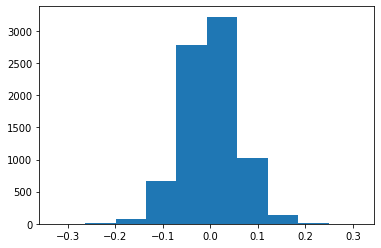

In [ ]:
print(LR_rel_red_reg_results.resid)
plt.hist(LR_rel_red_reg_results.resid)


name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.stattools.jarque_bera(LR_rel_red_reg_results.resid)
list(zip(name, test))

Jarque-Bera test:
H_0: the residues are normally distributed.
H_1: the resedues are not normally distributed.

Jarque-Bera value = 189.80, with p-value close to 0, we reject the null hypothesis. So the F-test cannot be reliably used to compare the goodness-of-fit of two competing regression models.

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

In [ ]:
import statsmodels.stats.api as sms
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(LR_rel_red_reg_results.resid, LR_rel_red_reg_results.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 1147.1761516429183),
 ('p-value', 4.210030478776378e-94),
 ('f-value', 4.04957047319814),
 ('f p-value', 1.048535613566696e-104)]

In [ ]:
print("residual mean = ", np.mean(LR_rel_red_reg_results.resid))

residual mean =  -1.0381743957026131e-16


In [ ]:
sms.stattools.durbin_watson(LR_rel_red_reg_results.resid)

1.9779352872662754

We do not see a clear improvement or deterioration of our linear model, but now we should see more meanningful coefficients: 

In [ ]:
coef_red_df = pd.DataFrame( LR_rel_red_reg_results.params[1:].reshape(1, LR_rel_red_reg_results.params.size-1), index = ["coef"] ,columns = relevance_to_rating_red_df.columns.delete(-1))
coef_red_df = coef_red_df.transpose()
coef_red_df["tagId"] = coef_red_df.index.str.extract("(\d+)").astype("int").to_numpy()
coef_red_df=coef_red_df.set_index("tagId").join(genome_tags_df.set_index("tagId"), on ="tagId")
coef_red_significant_df = coef_red_df[ abs(coef_red_df["coef"]) > 0.1]
coef_red_significant_df

,coef,tag
tagId,,
1,-0.122100,007
3,0.120059,18th century
4,0.194422,1920s
15,0.161166,aardman
24,-0.298124,adapted from:game
...,...,...
1048,-1.137372,truman capote
1068,-0.371909,vampire human love
1078,0.277955,vienna


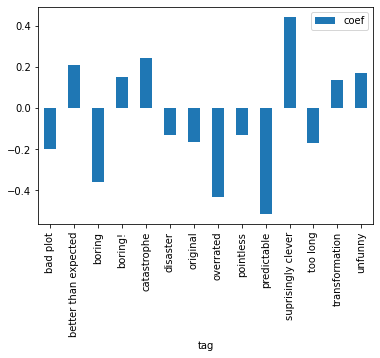

In [ ]:
coef_red_significant_df.plot( "tag", "coef", "bar")

Now we try adding second order terms into this model. But due to the high number of features it will be, the model till tend to overfit and it is computationally expensive. So we first remove mojarity of the feature using the correlation filter method.

In [ ]:
cutoff = 0.25
upper = relevance_corr_df.where(np.triu(np.ones(relevance_corr_df.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if (any(upper[column] > cutoff) or any(upper[column] < -cutoff))]
relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)

m,n = relevance_to_rating_red_df.shape
relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_red_tr.shape)
print("cross validation set shape", relevance_to_rating_red_cv.shape)
print("test set shape", relevance_to_rating_red_ts.shape)
X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-1]
y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-1]
X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-1]
y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-1]
X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-1]
y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-1]

from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)
Xp_relevance_to_rating_red_tr = polynomial_features.fit_transform(X_relevance_to_rating_red_tr)
Xp_relevance_to_rating_red_cv = polynomial_features.fit_transform(X_relevance_to_rating_red_cv)


LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(Xp_relevance_to_rating_red_tr))
for alpha in [0, 0.0001, 0.0003, 0.001, 0.003]:
    Alpha = np.ones( Xp_relevance_to_rating_red_tr.shape[1] ) * alpha
    Alpha[0] = 0 # do not penalize the constant coefficient
    LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
    LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(Xp_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
    LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(Xp_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
    print("When cutoff, alpha =", cutoff, ", " , alpha)
    print("Training MSE:", LR_rel_red_reg_MSE_tr)
    print("Cross validation MSE:", LR_rel_red_reg_MSE_cv, "\n")

training set shape (7905, 49)
cross validation set shape (2635, 49)
test set shape (2636, 49)
When cutoff, alpha = 0.25 ,  0
Training MSE: 0.06590622037822969
Cross validation MSE: 0.2282175676574592 

When cutoff, alpha = 0.25 ,  0.0001
Training MSE: 0.09149811544477117
Cross validation MSE: 0.09582310176210453 

When cutoff, alpha = 0.25 ,  0.0003
Training MSE: 0.10308867692190334
Cross validation MSE: 0.10578553093974036 

When cutoff, alpha = 0.25 ,  0.001
Training MSE: 0.12160623401011302
Cross validation MSE: 0.12346053715146145 

When cutoff, alpha = 0.25 ,  0.003
Training MSE: 0.14093437308494347
Cross validation MSE: 0.14234586675485797 



Now the model is making siginificantly more errors.

Remove random features to ease overfitting:

In [ ]:
p = 0.01
m,n = relevance_to_rating_df.shape
print(m,n)
to_drop = np.random.binomial(1,p,(n))
to_drop[-1] = 0
to_drop = relevance_to_rating_df.columns.where(to_drop)
to_drop = to_drop.dropna()
relevance_to_rating_red_df = relevance_to_rating_df.drop(columns = to_drop)

relevance_to_rating_red_df
m,n = relevance_to_rating_red_df.shape
relevance_to_rating_red_tr, relevance_to_rating_red_cv, relevance_to_rating_red_ts = np.split(relevance_to_rating_red_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
print("training set shape", relevance_to_rating_red_tr.shape)
print("cross validation set shape", relevance_to_rating_red_cv.shape)
print("test set shape", relevance_to_rating_red_ts.shape)
X_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,:-1]
y_relevance_to_rating_red_tr = relevance_to_rating_red_tr[:,-1]
X_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,:-1]
y_relevance_to_rating_red_cv = relevance_to_rating_red_cv[:,-1]
X_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,:-1]
y_relevance_to_rating_red_ts = relevance_to_rating_red_ts[:,-1]
LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_red_tr, sm.add_constant(X_relevance_to_rating_red_tr))

for alpha in [0.0003]:
  Alpha = np.ones( X_relevance_to_rating_red_tr.shape[1]+1 ) * alpha
  Alpha[0] = 0 # do not penalize the constant coefficient
  LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
  LR_rel_red_reg_MSE_tr = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_tr), y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
  LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_red_cv), y_relevance_to_rating_red_cv, LR_rel_red_reg_results)
  print("When probability, alpha =", p, ", ", alpha,)
  print("Dropped columns", to_drop)
  print("Training MSE:", LR_rel_red_reg_MSE_tr)
  print("Cross validation MSE:", LR_rel_red_reg_MSE_cv, "\n")

13176 1129
training set shape (7905, 1119)
cross validation set shape (2635, 1119)
test set shape (2636, 1119)
When probability, alpha = 0.01 ,  0.0003
Dropped columns Index(['relevance to tag 12', 'relevance to tag 230', 'relevance to tag 403',
       'relevance to tag 458', 'relevance to tag 669', 'relevance to tag 847',
       'relevance to tag 889', 'relevance to tag 919', 'relevance to tag 1049',
       'relevance to tag 1097'],
      dtype='object')
Training MSE: 0.00317387002254649
Cross validation MSE: 0.004159263109007722 



Removing feature one by one to achieve the lowest CV MSE:

In [ ]:
RUN = False #this block takes forever to run

if RUN:
  m,n = relevance_to_rating_df.shape
  print(m,n)
  relevance_to_rating_tr, relevance_to_rating_cv, relevance_to_rating_ts = np.split(relevance_to_rating_df.sample(frac=1, random_state = 200).to_numpy(), [int(.6 * m), int(.8 * m)])
  X_relevance_to_rating_tr = relevance_to_rating_tr[:,:-1]
  y_relevance_to_rating_tr = relevance_to_rating_tr[:,-1]
  X_relevance_to_rating_cv = relevance_to_rating_cv[:,:-1]
  y_relevance_to_rating_cv = relevance_to_rating_cv[:,-1]
  X_relevance_to_rating_ts = relevance_to_rating_ts[:,:-1]
  y_relevance_to_rating_ts = relevance_to_rating_ts[:,-1]

  X1_relevance_to_rating_tr = sm.add_constant(X_relevance_to_rating_tr)
  column_remains = np.arange(n)

  MSE_cv_lowest = 1
  j_to_drop = 1
  to_drop = []
  for i in range(1):
    l = column_remains.size
    #for j in range(1,l-1):
    for j in range(1110,l-1):
      print("Trying on tag #", j)
      if j< l-1:
        X1_relevance_to_rating_red_tr = X1_relevance_to_rating_tr[:,np.append (column_remains[0:j], column_remains[j+1:])]
      else:
        X1_relevance_to_rating_red_tr = X1_relevance_to_rating_tr[:,column_remains[0:j-1]]

      LR_rel_red_reg_model = sm.OLS(y_relevance_to_rating_tr, X1_relevance_to_rating_red_tr)
      Alpha = np.ones( X1_relevance_to_rating_red_tr.shape[1] ) * 0.0003
      Alpha[0] = 0 # do not penalize the constant coefficient
      LR_rel_red_reg_results = LR_rel_red_reg_model.fit_regularized(alpha = Alpha, L1_wt = 0)
      #LR_rel_red_reg_MSE_tr = compute_LR_MSE(X1_relevance_to_rating_red_tr, y_relevance_to_rating_red_tr, LR_rel_red_reg_results)
      LR_rel_red_reg_MSE_cv = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_cv)[:,np.append (column_remains[0:j], column_remains[j+1:])], y_relevance_to_rating_cv, LR_rel_red_reg_results)
      LR_rel_red_reg_MSE_ts = compute_LR_MSE(sm.add_constant(X_relevance_to_rating_ts)[:,np.append (column_remains[0:j], column_remains[j+1:])], y_relevance_to_rating_ts, LR_rel_red_reg_results)
      print("MSE_cv", LR_rel_red_reg_MSE_cv)
      print("MSE_ts", LR_rel_red_reg_MSE_ts)

      if LR_rel_red_reg_MSE_cv < MSE_cv_lowest:
        MSE_cv_lowest = LR_rel_red_reg_MSE_cv
        j_to_drop = j

    to_drop.append(j_to_drop)
    column_remains = np.append (column_remains[0:j_to_drop], column_remains[j_to_drop+1:])
    print("Tag #", j_to_drop, "is dropped.")
    print(MSE_cv_lowest)

  print("to_drop:", to_drop)

**Controversy scores.**

Correlation Heatmap

In [ ]:
movie_industry_df = pd.read_csv('s3://citadel-datathon-datasets/movie_industry.csv',encoding='latin-1')
oscar_awards_df = pd.read_csv('s3://citadel-datathon-datasets/the_oscar_award.csv')
movie_industry_df['company'] = movie_industry_df['company'].astype('category')
movie_industry_df['country'] = movie_industry_df['country'].astype('category')
movie_industry_df['director'] = movie_industry_df['director'].astype('category')
movie_industry_df['genre'] = movie_industry_df['genre'].astype('category')
movie_industry_df['rating'] = movie_industry_df['rating'].astype('category')
movie_industry_df['released'] = pd.to_datetime(movie_industry_df['released'])
movie_industry_df['star'] = movie_industry_df['star'].astype('category')

award_count_by_film = oscar_awards_df.where(oscar_awards_df['winner'] == True).groupby('film').aggregate('count')['winner']
movie_industry_df = movie_industry_df.join(pd.DataFrame({'film': award_count_by_film.index, 'num_awards': award_count_by_film.values}).set_index('film'), on='name', how='left')
movie_industry_df['num_awards'] = movie_industry_df['num_awards'].fillna(0)

In [ ]:
ratings_df = pd.read_csv('s3://citadel-datathon-datasets/ratings.csv')

ratings_stats = ratings_df \
  .groupby('movieId')['rating'] \
  .agg([
    'mean', 
    'count', 
    'std', 
    ('first_quartile', lambda ratings: ratings.quantile(0.25)),
    ('second_quartile', lambda ratings: ratings.quantile(0.50)),
    ('third_quartile', lambda ratings: ratings.quantile(0.75))
  ])

In [ ]:
movies_df = pd.read_csv('s3://citadel-datathon-datasets/movies.csv')
ratings_stats2 = movies_df.join(ratings_stats, on='movieId', how='inner')
ratings_stats2['year'] = ratings_stats2['title'].str.extract(r'\(([0-9]{4})\)$')
ratings_stats2 = ratings_stats2[~ratings_stats2['year'].isnull()]
ratings_stats2['year'] = ratings_stats2['year'].astype('int')
ratings_stats2['title'].replace(to_replace=r' \([0-9]{4}\)$', value="", regex=True, inplace=True)

movie_industry_df = movie_industry_df.merge(ratings_stats2, left_on=['name', 'year'], right_on=['title', 'year'], how='inner')

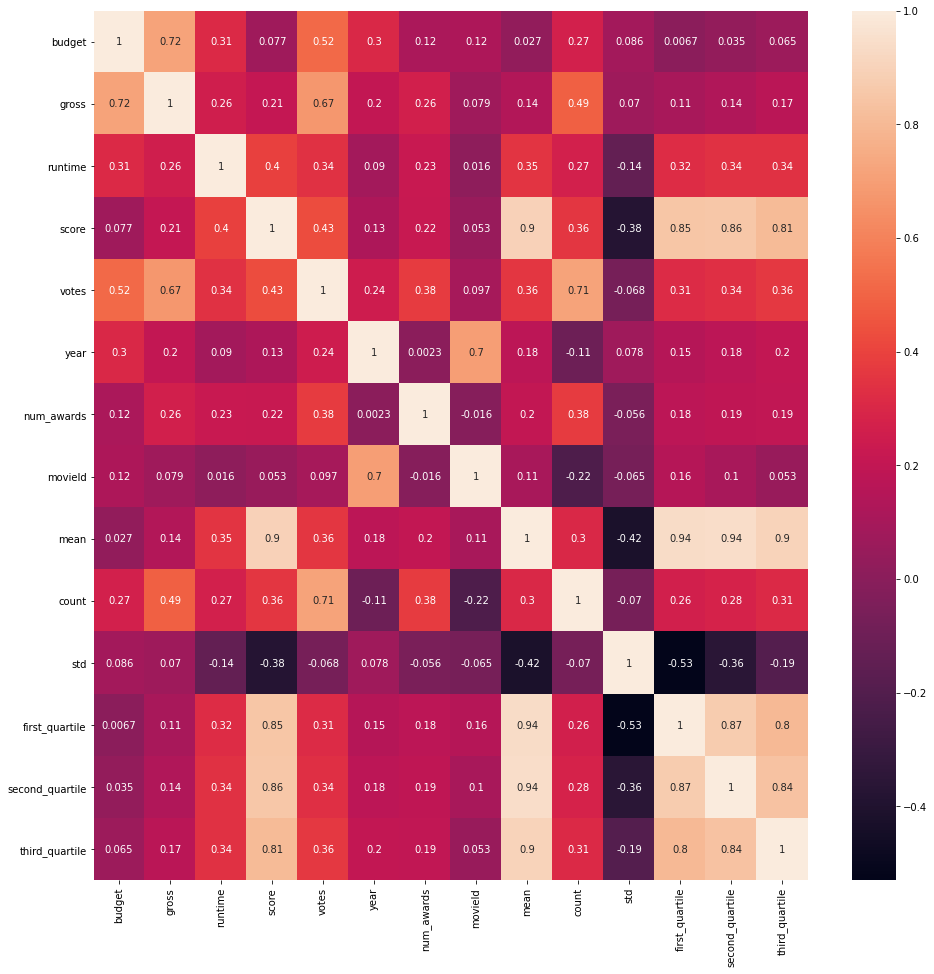

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(movie_industry_df.corr(method='pearson'), annot=True)